<a id='top'><img src='https://media.giphy.com/media/YVfSBbePrWdGw/giphy.gif'></a>
<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#data" role="tab" aria-controls="profile">Fetch the data<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#down" role="tab" aria-controls="messages">Downcasting<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#melt" role="tab" aria-controls="settings">Melting the data<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#eda" role="tab" aria-controls="settings">Exploratory Data Analysis<span class="badge badge-primary badge-pill">4</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#fe" role="tab" aria-controls="settings">Feature Engineering<span class="badge badge-primary badge-pill">5</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#pred" role="tab" aria-controls="settings">Modelling and Prediction<span class="badge badge-primary badge-pill">6</span></a>

In [1]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

# <a id='data'>1. Fetch the data</a>

In [2]:
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
prices.name = 'prices'

FileNotFoundError: [Errno 2] File /kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv does not exist: '/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv'

Since, the validation data is now available for the days 1914-1941, Adding zero sales for days: d_1942 - d_1969(Test)

In [ ]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

# <a id='down'>2. Downcasting</a>
In this section I'll be downcasting the dataframes to reduce the amount of storage used by them and also to expidite the operations performed on them.

<img src='https://media.giphy.com/media/VGP4koIBvIWDP2umDU/giphy.gif' style="width:500px;height:300px;">

- **Numerical Columns: ** Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.<br>
Here are the different subtypes you can use:<br>
`int8 / uint8` : consumes 1 byte of memory, range between -128/127 or 0/255<br>
`bool` : consumes 1 byte, true or false<br>
`float16 / int16 / uint16`: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535<br>
`float32 / int32 / uint32` : consumes 4 bytes of memory, range between -2147483648 and 2147483647<br>
`float64 / int64 / uint64`: consumes 8 bytes of memory<br>
If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!
- **Categorical Columns: ** Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [ ]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [ ]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

Below plot shows how much effect downcasting has had on the memory usage of DataFrames. Clearly, we have been able to reduce `sales` & `prices` to less than 1/4th of their actual memory usage. `calendar` is already a small dataframe.

In [ ]:
dic = {'DataFrame':['sales','calendar','prices'],
       'Before downcasting':[sales_bd,calendar_bd,prices_bd],
       'After downcasting':[sales_ad,calendar_ad,prices_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Effect of Downcasting')
fig.show()

# <a id='melt'>3. Melting the data</a>
Currently, the data is in three dataframes: `sales`, `prices` & `calendar`. The `sales` dataframe contains daily sales data with days(d_1 - d_1969) as columns. The `prices` dataframe contains items' price details and `calendar` contains data about the days d.  
<img src='https://media.giphy.com/media/Qbt9STC0qpSuc/giphy.gif' style="width:500px;height:300px;">
<h2 style="background-color:DodgerBlue; color:white" >3.1 Convert from wide to long format</h2>
Here's an example of conversion of a wide dataframe to a long dataframe.
<img src='https://pandas.pydata.org/pandas-docs/version/0.25.0/_images/reshaping_melt.png' style="width:600px;height:300px;">

In this case what the melt function is doing is that it is converting the sales dataframe which is in wide format to a long format. I have kept the id variables as `id`, `item_id`, `dept_id`, `cat_id`, `store_id` and `state_id`. They have in total 30490 unique values when compunded together. Now the total number of days for which we have the data is 1969 days. Therefore the melted dataframe will be having 30490x1969 i.e. 60034810 rows

In [ ]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

<h2 style="background-color:DodgerBlue; color:white" >3.2 Combine the data</h2>
Combine price data from prices dataframe and days data from calendar dataset.

In [ ]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

<h3>Now I have a single and a complete dataframe with all the data required. Let's Explore!</h3>

# <a id='eda'>4. Exploratory Data Analysis</a>
<h2 style="background-color:DodgerBlue; color:white" >4.1 The Dataset</h2>
The M5 dataset, generously made available by Walmart, involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI).
<img src='https://i.imgur.com/Ae5QBi9.png' style="width:500px;height:300px;">
I have drawn an interactive visualization showing the distribution of 3049 items across different aggregation levels.

In [ ]:
group = sales.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'United States of America'
group.rename(columns={'state_id':'State','store_id':'Store','cat_id':'Category','dept_id':'Department','item_id':'Count'},inplace=True)
fig = px.treemap(group, path=['USA', 'State', 'Store', 'Category', 'Department'], values='Count',
                  color='Count',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribution of items')
fig.update_layout(template='seaborn')
fig.show()

<h2 style="background-color:DodgerBlue; color:white" >4.2 Item Prices</h2>
Here I'll be studying about the item prices and their distribution. Please note the prices vary weekly. So to study the distribution of prices I have taken their average.

In [ ]:
group_price_store = df.groupby(['state_id','store_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores',legend_title_text='State')
fig.show()

Below are some of the observations from the above plot:-
<ul style="list-style-type:circle;">
  <li>The distribution of item prices is almost uniform for all the stores across Califoria, Texas and Wisconsin.</li>
  <li>Item <b>HOBBIES_1_361</b> priced at around 30.5 dollars is the costliest item being sold at walmarts across California.</li>
  <li>Item <b>HOUSEHOLD_1_060</b> priced at around 29.875 dollars is the costliest item being sold at walmarts across Texas.</li>
  <li>Item <b>HOBBIES_1_361</b> priced at around 30.48 dollars is the costliest item being sold at TX_1 and TX_3 in Texas. While item <b>HOBBIES_1_255</b> priced at around 30.5 dollars is the costliest at TX_2</li>
</ul>

In [ ]:
group_price_cat = df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices wrt Stores across Categories',
                 legend_title_text='Category')
fig.show()

As can be seen from the plot above, food category items are quite cheap as compared with hobbies and household items. Hobbies and household items have almost the same price range.

<h2 style="background-color:DodgerBlue; color:white" >4.3 Items Sold</h2>
Let's study the sales accross all the stores.

In [ ]:
group = df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True)
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Total items sold')
fig.update_layout(template='seaborn',title='Distribution of Items sold wrt Stores',legend_title_text='State')
fig.show()

Below are some of the observations from the above plot:-
<ul style="list-style-type:circle;">
  <li><b><u>California</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
  <li><b><u>Texas</u></b>: <b>TX_2</b> and **TX_3** have sold the maximum number of items. <b>TX_1</b> has sold the least number of items.</li>
  <li><b><u>Wisconsin</u></b>: <b>WI_2</b> has sold the maximum number of items while, <b>WI_3</b> has sold the least number of items.</li>
  <li><b><u>USA</u></b>: <b>CA_3</b> has sold the most number of items while, <b>CA_4</b> has sold the least number of items.</li>
</ul>

**Let's study number of items sold over time across all the stores.**

In [ ]:
fig = go.Figure()
title = 'Items sold over time'
years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sold'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.33, 0.66],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title = 'TX',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.66, 1],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks='',
        title="CA",
        titlefont={"size":20},
        type="linear",
        zeroline=False
    )
    )
fig.update_layout(template='seaborn', title=title)
fig.show()

<h2 style="background-color:DodgerBlue; color:white" >4.4 State wise Analysis</h2>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#cal" role="tab" aria-controls="profile">California<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#tex" role="tab" aria-controls="messages">Texas<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#wis" role="tab" aria-controls="settings">Wisconsin<span class="badge badge-primary badge-pill">3</span></a>
<br>
In this section, I will be studying the sales and revenue of all the stores individually across all the three states: California, Texas & Wisconsin. I have plotted total three plots for each store: CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2 & WI_3. Details about the plots are as follows:-
- First plot shows the daily sales of a store. I have plotted the values separately for SNAP days. Also, SNAP promotes food purchase, I have plotted food sales as well to check if it really affects the food sales.
- Second plot shows the daily revenue of a store with separate plotting for <a href='#SNAP'>SNAP</a> days.
- Third is a heatmap to show daily sales. It's plotted in such a way that it becomes easier to see day wise values.

<div class="alert alert-info" role="alert">
<a id='SNAP'><b>What is SNAP?</b></a><br>
The United States federal government provides a nutrition assistance benefit called the Supplement Nutrition Assistance Program (SNAP).  SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products.  In many states, the monetary benefits are dispersed to people across 10 days of the month and on each of these days 1/10 of the people will receive the benefit on their card.  More information about the SNAP program can be found [here.](https://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program)
</div>

<div class="alert alert-danger" role="alert">
For the heatmaps, the data is till 16th week of 2016 and datetime.weekofyear of function is returning 1,2 & 3 january of 2016 in 53rd week. Plotly's heatmap is connecting the data gap between the 16th and 53rd week. Still figuring out on how to remove this gap.
</div>

In [ ]:
df['revenue'] = df['sold']*df['sell_price'].astype(np.float32)

In [ ]:
def introduce_nulls(df):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_metric(df,state,store,metric):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<='2016-05-22')]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],
                           name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],
                           name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total items sold' if metric=='sold' else 'Total revenue($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2011-01-29','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(count=3,
                     label="3y",
                     step="year",
                     stepmode="backward"),
                dict(count=4,
                     label="4y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ))
    return fig

In [ ]:
cal_data = group.copy()
cal_data = cal_data[cal_data.date <= '22-05-2016']
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()

In [ ]:
def calmap(cal_data, state, store, scale):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title=store)
    return fig

<a id="cal" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">California</a>
<img src='https://www.pixel4k.com/wp-content/uploads/2018/09/san-francisco-california-cityscape-4k_1538070292.jpg'
style="width:800px;height:300px;">

<a id='csn'><span class="label label-info">Store Navigator</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#C1'>CA_1</a></li>
    <li class="page-item"><a class="page-link" href="#C2">CA_2</a></li>
    <li class="page-item"><a class="page-link" href="#C3">CA_3</a></li>
    <li class="page-item"><a class="page-link" href="#C4">CA_4</a></li>
  </ul>
</nav>

### <a id='C1'>CA_1</a>

In [ ]:
fig = plot_metric(df,'CA','CA_1','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_1','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'CA', 'CA_1', 'magma')
fig.show()

### <a id='C2'>CA_2</a>
<a href='#csn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'CA','CA_2','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_2','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'CA', 'CA_2', 'magma')
fig.show()

### <a id='C3'>CA_3</a>
<a href='#csn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'CA','CA_3','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_3','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'CA', 'CA_3', 'magma')
fig.show()

### <a id='C4'>CA_4</a>
<a href='#csn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'CA','CA_4','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_4','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'CA', 'CA_4', 'magma')
fig.show()

<a id="tex" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">Texas</a>
<img src='https://wallpaperaccess.com/full/227248.jpg'
style="width:800px;height:300px;">
<a id='wsn'><span class="label label-info">Store Navigator</span></a>
<a id='tsn'><nav aria-label="Store Navigator"></a>
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#T1'>TX_1</a></li>
    <li class="page-item"><a class="page-link" href="#T2">TX_2</a></li>
    <li class="page-item"><a class="page-link" href="#T3">TX_3</a></li>
  </ul>
</nav>

### <a id='T1'>TX_1</a>

In [ ]:
fig = plot_metric(df,'TX','TX_1','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_1','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'TX', 'TX_1', 'viridis')
fig.show()

### <a id='T2'>TX_2</a>
<a href='#tsn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'TX','TX_2','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_2','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'TX', 'TX_2', 'viridis')
fig.show()

### <a id='T3'>TX_3</a>
<a href='#wsn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'TX','TX_3','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_3','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'TX', 'TX_3', 'viridis')
fig.show()

<a id="wis" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">Wisconsin</a>
<img src='https://i.ytimg.com/vi/RzETB_wVAKI/maxresdefault.jpg'
style="width:800px;height:300px;">
<span class="label label-info">Store Navigator</span>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#W1'>WI_1</a></li>
    <li class="page-item"><a class="page-link" href="#W2">WI_2</a></li>
    <li class="page-item"><a class="page-link" href="#W3">WI_3</a></li>
  </ul>
</nav>

### <a id='W1'>WI_1</a>

In [ ]:
fig = plot_metric(df,'WI','WI_1','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'WI','WI_1','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'WI', 'WI_1', 'twilight')
fig.show()

### <a id='W2'>WI_2</a>
<a href='#wsn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'WI','WI_2','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'WI','WI_2','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'WI', 'WI_2', 'twilight')
fig.show()

### <a id='W3'>WI_3</a>
<a href='#tsn'><span class="label label-info">Go to the Store Navigator</span></a>

In [ ]:
fig = plot_metric(df,'WI','WI_3','sold')
fig.show()

In [ ]:
fig = plot_metric(df,'WI','WI_3','revenue')
fig.show()

In [ ]:
fig = calmap(cal_data, 'WI', 'WI_3', 'twilight')
fig.show()

# <a id='fe'>5. Feature Engineering</a>
Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

<img src='https://media.giphy.com/media/yv1ggi3Cbase05a8iS/giphy.gif' style="width:500px;height:300px;">

The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.

<a id='topics'><span class="label label-info">Topics</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#F1'>Label Encoding</a></li>
    <li class="page-item"><a class="page-link" href="#F2">Introduce Lags</a></li>
    <li class="page-item"><a class="page-link" href="#F3">Mean Encoding</a></li>
    <li class="page-item"><a class="page-link" href="#F4">Rolling Window Stats</a></li>
    <li class="page-item"><a class="page-link" href="#F5">Expanding Window Stats</a></li>
    <li class="page-item"><a class="page-link" href="#F6">Trends</a></li>
    <li class="page-item"><a class="page-link" href="#F7">Save the data</a></li>
  </ul>
</nav>

<a id = 'F1'><h2>5.1 Label Encoding</h2></a>
<ol>
  <li>Remove unwanted data to create space in RAM for further processing.</li>
  <li>Label Encode categorical features.(I had converted already converted categorical variable to category type. So, I can simply use their codes instead of using LableEncoder)</li>
  <li>Remove date as its features are already present.</li>
</ol>

<div class="alert alert-info" role="alert">
<b>Please note:</b><br>
I'm storing the categories correponding to their respective category codes so that I'can use them later on while making the submission.
</div>

In [ ]:
#Store the categories along with their codes
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [ ]:
#1
del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data
gc.collect();

#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
df.drop('date',axis=1,inplace=True)

<a id = 'F2'><h2>5.2 Introduce Lags</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

Introduce lags to the the target variable `sold`. The maximum lag I have introduced is 36 days. It's purely upto you how many lags you want to introduce.

In [ ]:
#Introduce lags
lags = [1,2,3,6,12,24,36]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

<a id = 'F3'><h2>5.3 Mean Encoding</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value. I have calculated mean encodings on the basis of following logical features I could think of:-
- item
- state
- store
- category
- department
- category & department
- store & item
- category & item
- department & item
- state & store
- state, store and category
- store, category and department

<h2>Feel free to add more!</h2>

In [ ]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

<a id = 'F4'><h2>5.4 Rolling Window Statistics</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Here’s an awesome gif that explains this idea in a wonderfully intuitive way:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif)
`This method is called the rolling window method because the window would be different for every data point.`

I'll be calculating weekly rolling avearge of the items sold. More features like rolling min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [ ]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

<a id = 'F5'><h2>5.5 Expanding Window Statistics</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values. Here’s a gif that explains how our expanding window function works:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/12/output_B4KHcT.gif)

I'll be calculating expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [ ]:
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

<a id = 'F6'><h2>5.6 Trends</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

I will be creating a selling trend feature, which will be some positive value if the daily items sold are greater than the entire duration average **( d_1 - d_1969 )** else negative. More trend features can be added but I'll only add this one to keep it simple.

In [55]:
df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

<a id = 'F6'><h2>5.7 Save the data</h2></a>
<a href='#topics'><span class="label label-info">Go back to topics</span></a>

Now since all the new features are created, let's save the data so that it can be trained separately.Also, lags introduce a lot of Null values, so I'll remove data for first 35 days as I have introduced lags till 36 days.

In [56]:
df = df[df['d']>=36]

Let's look at our new dataframe.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58967660 entries, 1067150 to 60034809
Data columns (total 44 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_price      

Save the data for training.

In [58]:
df.to_pickle('data.pkl')
del df
gc.collect();

# <a id='pred'>6. Modelling and Prediction</a>

In [59]:
data = pd.read_pickle('data.pkl')
valid = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [60]:
#Get the store ids
stores = sales.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]
    
    #Split the data
    X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
    X_test = df[df['d']>=1942].drop('sold',axis=1)
    
    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = 'model'+str(d_store_id[store])+'.pkl'
    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: CA_1*****
Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.664648	training's l2: 0.441757	valid_1's rmse: 0.409088	valid_1's l2: 0.167353
[40]	training's rmse: 0.620605	training's l2: 0.385151	valid_1's rmse: 0.382771	valid_1's l2: 0.146514
[60]	training's rmse: 0.592515	training's l2: 0.351074	valid_1's rmse: 0.363248	valid_1's l2: 0.131949
[80]	training's rmse: 0.576537	training's l2: 0.332395	valid_1's rmse: 0.355633	valid_1's l2: 0.126475
[100]	training's rmse: 0.567014	training's l2: 0.321505	valid_1's rmse: 0.349251	valid_1's l2: 0.121976
[120]	training's rmse: 0.557461	training's l2: 0.310763	valid_1's rmse: 0.346747	valid_1's l2: 0.120233
[140]	training's rmse: 0.551658	training's l2: 0.304326	valid_1's rmse: 0.34541	valid_1's l2: 0.119308
[160]	training's rmse: 0.540417	training's l2: 0.29205	valid_1's rmse: 0.341793	valid_1's l2: 0.116822
[180]	training's rmse: 0.532797	training's l2: 0.283873	valid_1's rmse: 0.33

**Plotting feature importances**

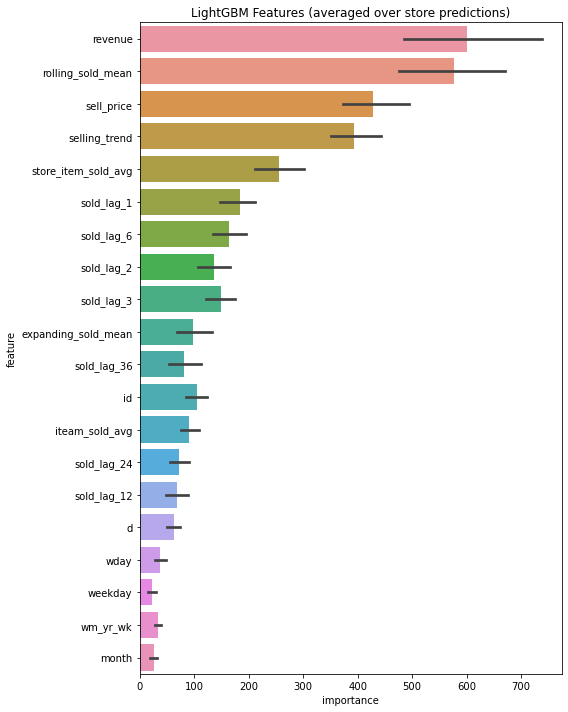

In [61]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir('/kaggle/working/'):
    if 'model' in filename:
        # load model
        model = joblib.load(filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

**Make the submission**

If you remember for EDA, feature engineering and training I had melted the provided data from wide format to long format. Now, I have the predictions in long format but the format to be evaluated for the competition is in long format. Therefore, I'll convert it into wide format using `pivot` function in pandas. Below is an image explaining the pivot function.
<img src='https://pandas.pydata.org/pandas-docs/version/0.25.3/_images/reshaping_pivot.png' style="width:500px;height:300px;">

In [62]:
#Set actual equal to false if you want to top in the public leaderboard :P
actual = False
if actual == False:
    #Get the validation results(We already have them as less than one month left for competition to end)
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation['id']=pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv').id
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
else:
    #Get the actual validation results
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

#Get the evaluation results
test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
#Remap the category id to their respective categories
evaluation.id = evaluation.id.map(d_id)

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)

![](https://media.giphy.com/media/APHFMUIaTnLIA/giphy.gif)
## Do leave an upvote if you liked it. It will encourage me to produce more quality content :)
<a href="#top" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>